Importing packages:

In [2031]:
from firedrake import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

Initialising parameters, mesh, function spaces and functions:

In [2032]:
epsilon = 1
k = 100

In [2033]:
N = 10
mesh = UnitSquareMesh(N, N)

In [2034]:
V = VectorFunctionSpace(mesh, "DG", degree=1, dim=2)
Q = FunctionSpace(mesh, "CG", degree=2)
W = V * Q

#do not implement Dirichlet bcs because for sin^2(pi*x)sin^2(pi*y) they happen to exist by design
#boundary_ids = (1, 2, 3, 4)
#bcs = DirichletBC(W.sub(1), 0, boundary_ids)

In [2035]:
x, y = SpatialCoordinate(mesh)
u_exact = sin(pi*x)**2*sin(pi*y)**2
f = (-epsilon + k*1j)**2*u_exact + pi**2*(cos(2*pi*(x+y)) + cos(2*pi*(x-y)) - cos(2*pi*x) - cos(2*pi*y))

Implementing the pHSS iteration:

In [2036]:
def pHSS_iteration(sigma_old, u_old, k, epsilon, f):
    sigma_new = TrialFunction(V)
    u_new = TrialFunction(Q)
    tau = TestFunction(V)
    v = TestFunction(Q)
    
    #solving for u_new
    a = (inner(grad(u_new), grad(v))*dx
         + inner(Constant((-epsilon+1j)**2*k**2)*u_new, v)*dx
         - inner(Constant((-epsilon+1j)*k**2)*u_new, v)*ds)
    L = (Constant((k-1)/(k+1))*(inner(Constant(-2*epsilon*k)*sigma_old, grad(v))*dx
                                - inner(grad(u_old), grad(v))*dx
                                + inner(Constant((epsilon**2 + 1)*k**2)*u_old, v)*dx
                                - inner(Constant((-epsilon+1j)*k**2)*u_old, v)*ds)
         + inner(Constant((-epsilon+1j)*2*k**2/((k+1)*(-epsilon+k*1j)))*f, v)*dx)

    uh = Function(Q)
    solve(a == L, uh, solver_parameters={"ksp_type": "preonly",
                                            "pc_type": "lu",
                                            "pc_mat_factor_solver_type": "mumps",
                                            "mat_type": "aij"})
    
    #solving for sigma_new
    a = inner(Constant((epsilon-1j)*k)*sigma_new, tau)*dx
    L = (Constant((k-1)/(k+1))*(inner(Constant((epsilon+1j)*k)*sigma_old, tau)*dx
                                + inner(grad(u_old), tau)*dx)
         + inner(grad(uh), tau)*dx)
    
    sigmah = Function(V)
    solve(a == L, sigmah, solver_parameters={"ksp_type": "preonly",
                                                "pc_type": "lu",
                                                "pc_mat_factor_solver_type": "mumps",
                                                "mat_type": "aij"})
    
    return sigmah, uh

Testing the pHSS iteration:

In [2037]:
sigma_old = interpolate(Constant((0,0), mesh), V)
u_old = interpolate(Constant(0, mesh), Q)

In [2038]:
sigmah, uh = pHSS_iteration(sigma_old, u_old, k, epsilon, f)

Implementing the pHSS algorithm:

In [2039]:
def pHSS(sigma_0, u_0, k, epsilon, f, iters):
    sigma = sigma_0
    u = u_0
    
    for i in range(max(1, int(iters))):
        sigma, u = pHSS_iteration(sigma, u, k, epsilon, f)
    
    return sigma, u

Testing the pHSS algorithm:

In [2040]:
sigma_0 = interpolate(Constant((0,0), mesh), V)
u_0 = interpolate(Constant(0, mesh), Q)

In [2041]:
sigma, u = pHSS(sigma_0, u_0, k, epsilon, f, iters=10)

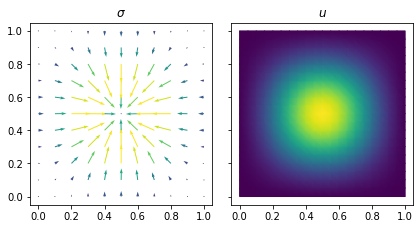

In [2042]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

quiver(sigma, axes=axes[0])
axes[0].set_aspect("equal")
axes[0].set_title("$\sigma$")

tripcolor(u, axes=axes[1])
axes[1].set_aspect("equal")
axes[1].set_title("$u$")

plt.tight_layout()

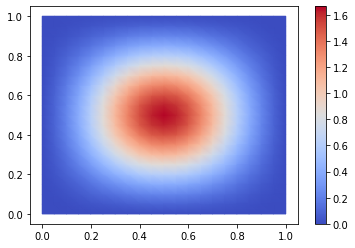

In [2043]:
fig, axes = plt.subplots()
collection = tripcolor(u, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

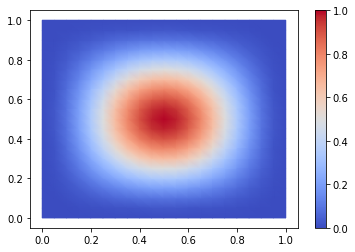

In [2044]:
u_interpolated = assemble(interpolate(u_exact, Q))
fig, axes = plt.subplots()
collection = tripcolor(u_interpolated, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

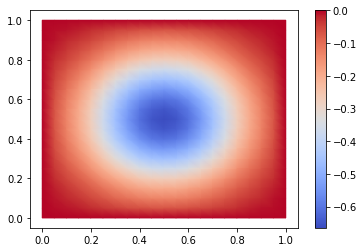

In [2045]:
difference = assemble(interpolate(u_exact, Q) - u)
fig, axes = plt.subplots()
collection = tripcolor(difference, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

In [1982]:
def error_grid(epsilon_arr, k_arr):
    errors = np.zeros((len(epsilon_arr), len(k_arr)))
    
    for i, epsilon in enumerate(epsilon_arr):
        for j, k in enumerate(k_arr):
            sigma, u = pHSS(sigma_0, u_0, k, epsilon, f, iters=10)
            errors[i, j] = errornorm(u_exact, u)

    return errors

In [1985]:
#epsilon_arr = np.logspace(-2,3,21)
#k_arr = np.logspace(-2,3,21)
epsilon_arr = np.logspace(-1,2,4)
k_arr = np.logspace(-1,1,3)

errors = error_grid(epsilon_arr, k_arr)

/var/folders/v8/m_l4288s40l13s5bx29ktz880000gn/T/ipykernel_7467/2219126415.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i, j] = errornorm(u_exact, u)


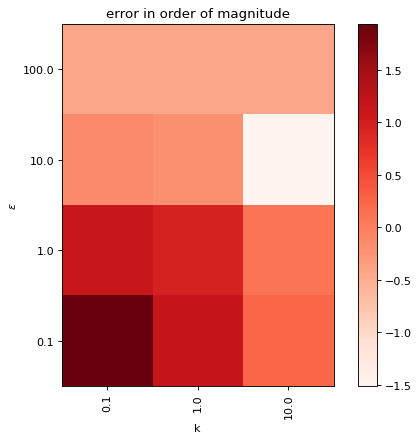

In [1986]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(np.log10(errors), cmap='Reds')
plt.xticks(np.arange(len(k_arr)), np.round(k_arr,2), rotation=90)
plt.xlabel('k')
plt.yticks(np.arange(len(epsilon_arr)), np.round(epsilon_arr,2))
plt.ylabel('$\epsilon$')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("error in order of magnitude")
plt.show()